#Dep

In [ ]:
!pip install statsforecast

#Point forecast

Random seed set to 42 for reproducibility.

Original rows: 541909
Rows after removing returns and zero price items: 530104
Capping Quantity at: 160.00

Rows before densification: 276148
Rows after densification: 1074653

Total series: 3922

Splitting data according to the paper's 'Fixed Origin' method...
After filtering series shorter than 30 days, 3649 series remain.
Initial Set Shape: (356291, 5)
Evaluation Set Shape: (716717, 5)
Optimizer successful: alpha_hat=0.9820, beta_hat=2.8333
MoM initial estimate: τ²_MoM = 0.666245
REML optimization successful: τ²_REML = 0.647251
Final estimates: σ²=1.258481, τ²=0.647251, k=1.9443, μ_GLS=1.5369


/Users/poyenchu/Personal/研究/TSB-HB/tsb-hb/.venv/lib/python3.9/site-packages/statsforecast/arima.py:572: RuntimeWarning: divide by zero encountered in matmul
  var = A.T @ sol
/Users/poyenchu/Personal/研究/TSB-HB/tsb-hb/.venv/lib/python3.9/site-packages/statsforecast/arima.py:572: RuntimeWarning: overflow encountered in matmul
  var = A.T @ sol
/Users/poyenchu/Personal/研究/TSB-HB/tsb-hb/.venv/lib/python3.9/site-packages/statsforecast/arima.py:572: RuntimeWarning: divide by zero encountered in matmul
  var = A.T @ sol
/Users/poyenchu/Personal/研究/TSB-HB/tsb-hb/.venv/lib/python3.9/site-packages/statsforecast/arima.py:572: RuntimeWarning: overflow encountered in matmul
  var = A.T @ sol
/Users/poyenchu/Personal/研究/TSB-HB/tsb-hb/.venv/lib/python3.9/site-packages/statsforecast/arima.py:572: RuntimeWarning: divide by zero encountered in matmul
  var = A.T @ sol
/Users/poyenchu/Personal/研究/TSB-HB/tsb-hb/.venv/lib/python3.9/site-packages/statsforecast/arima.py:572: RuntimeWarning: overflow encounte


Calculating naive error for RMSSE denominator...
Calculated RMSSE denominators for 3649 series.


/var/folders/24/mm4cs21103s6fp4sq0wvf_hr0000gn/T/ipykernel_31398/2134838649.py:232: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  eval_set_merged['TSB-HB-LogNormal'].fillna(0, inplace=True)


Evaluating model: index
Evaluating model: CrostonClassic
Evaluating model: CrostonSBA
Evaluating model: TSB
Evaluating model: ADIDA
Evaluating model: IMAPA
Evaluating model: AutoTheta
Evaluating model: AutoARIMA
Evaluating model: TSB-HB-LogNormal

=== Online Retail Results (Paper's Fixed Origin Method) ===
              model          ME         MAE        RMSE       RMSSE
8  TSB-HB-LogNormal   -0.797192    5.657495   17.777259    4.788721
4             ADIDA   -0.760293    5.686042   17.961724    4.796685
5             IMAPA   -0.759879    5.700035   17.996252    4.796959
3               TSB   -1.575077    5.573615   18.727224    4.803056
7         AutoARIMA   -0.962726    6.556774   20.141473    4.817146
6         AutoTheta   -1.808781    8.286168   22.471082    4.855029
2        CrostonSBA   -0.046753    6.195270   18.163275    5.069245
1    CrostonClassic    0.201045    6.329356   18.231957    5.105116
0             index  105.727392  107.292894  127.648991  230.585243

Generating 

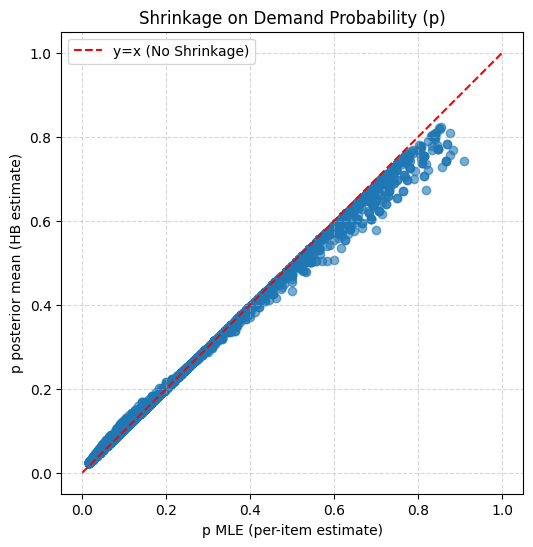

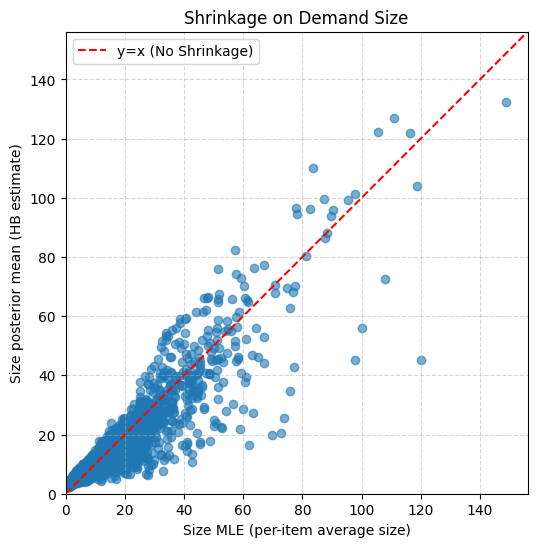

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.optimize as opt
from statsforecast import StatsForecast
from statsforecast.models import CrostonClassic, CrostonSBA, TSB, ADIDA, IMAPA, AutoARIMA, AutoTheta
import random
import os

# -------------------
# A) Set Random Seed for Reproducibility
# -------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
print(f"Random seed set to {SEED} for reproducibility.\n")


# -------------------
# 0) Load + Preprocess
# -------------------
FILE = "data/Online_Retail.csv"
df_raw = pd.read_csv(FILE, encoding="latin1")
df = df_raw[["InvoiceDate", "StockCode", "Quantity", "UnitPrice"]].copy()
print(f"Original rows: {len(df)}")
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)].copy()
print(f"Rows after removing returns and zero price items: {len(df)}")
q_cap = df['Quantity'].quantile(0.995)
print(f"Capping Quantity at: {q_cap:.2f}")
df['Quantity'] = df['Quantity'].clip(upper=q_cap)
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["ds"] = df["InvoiceDate"].dt.date
df = df.groupby(["StockCode", "ds"], as_index=False)["Quantity"].sum()
df = df.rename(columns={"StockCode":"unique_id", "Quantity":"y"})
df["ds"] = pd.to_datetime(df["ds"])
print(f"\nRows before densification: {len(df)}")
df = df.set_index('ds').groupby('unique_id')['y'].apply(
    lambda x: x.asfreq('D', fill_value=0)
).reset_index()
print(f"Rows after densification: {len(df)}")
print("\nTotal series:", df["unique_id"].nunique())
df = df.sort_values(["unique_id", "ds"])

# -------------------
# 1) Train/Test split
# -------------------
print("\nSplitting data according to the paper's 'Fixed Origin' method...")
INIT_RATIO = 1/3
MIN_LEN = 30
df['t'] = df.groupby('unique_id').cumcount()
df['L'] = df.groupby('unique_id')['t'].transform('max') + 1
df = df[df['L'] >= MIN_LEN].copy()
print(f"After filtering series shorter than {MIN_LEN} days, {df['unique_id'].nunique()} series remain.")
init_set = df[df['t'] < np.floor(df['L'] * INIT_RATIO)].copy()
eval_set = df[df['t'] >= np.floor(df['L'] * INIT_RATIO)].copy()
valid_ids = df['unique_id'].unique()
print(f"Initial Set Shape: {init_set.shape}")
print(f"Evaluation Set Shape: {eval_set.shape}")

# -------------------
# 2) TSB-HB Model
# -------------------
init_set["occ"] = (init_set["y"] > 0).astype(int)
init_set["size"] = np.where(init_set["occ"]==1, init_set["y"].astype(float), np.nan)
init_set["log_size"] = np.log(init_set["size"])
g_init = init_set.groupby("unique_id")
s = g_init["occ"].sum()
n = g_init["ds"].nunique()

def beta_binom_log_marginal(s:int, n:int, alpha:float, beta:float)->float:
    if alpha <= 0 or beta <= 0 or s < 0 or n < s: return -np.inf
    return (
        math.lgamma(n + 1) - math.lgamma(s + 1) - math.lgamma(n - s + 1) +
        math.lgamma(s + alpha) + math.lgamma(n - s + beta) - math.lgamma(n + alpha + beta) -
        (math.lgamma(alpha) + math.lgamma(beta) - math.lgamma(alpha + beta))
    )

def estimate_beta_hyperparams(counts: pd.DataFrame):
    s_arr, n_arr = counts["s"].astype(int).values, counts["n"].astype(int).values
    valid_indices = (n_arr > 0) & (s_arr <= n_arr)
    s_arr, n_arr = s_arr[valid_indices], n_arr[valid_indices]
    def objective_fn(params):
        alpha, beta = params
        if alpha <= 0 or beta <= 0: return np.inf
        log_likelihoods = [beta_binom_log_marginal(si, ni, alpha, beta) for si, ni in zip(s_arr, n_arr)]
        return -sum(log_likelihoods)
    initial_guess = [1.0, 10.0]
    bounds = [(1e-6, None), (1e-6, None)]
    result = opt.minimize(fun=objective_fn, x0=initial_guess, method='L-BFGS-B', bounds=bounds)
    if result.success:
        best_alpha, best_beta = result.x
        print(f"Optimizer successful: alpha_hat={best_alpha:.4f}, beta_hat={best_beta:.4f}")
        return float(best_alpha), float(best_beta)
    else:
        print("Optimizer failed, returning default values.")
        return 1.0, 1.0

alpha_hat, beta_hat = estimate_beta_hyperparams(pd.DataFrame({"s": s, "n": n}))
p_post_mean = (alpha_hat + s) / (alpha_hat + beta_hat + n)

# [MODIFIED] This function now uses a weighted average for pooled_var
from scipy.optimize import minimize

def estimate_log_normal_posterior_mean_REML(df_init):
    item_stats = df_init.groupby('unique_id')['log_size'].agg(
        n_pos='count', mean_log='mean', var_log='var'
    ).reset_index()
    item_stats = item_stats[item_stats['n_pos'] > 1].copy().fillna({'var_log': 0})

    if item_stats.empty:
        return pd.Series()

    # --- Step 1: Pooled within-item variance (weighted) ---
    numerator = np.sum((item_stats['n_pos'] - 1) * item_stats['var_log'])
    denominator = np.sum(item_stats['n_pos'] - 1)
    sigma_sq = numerator / denominator if denominator > 0 else 1e-6

    y_i = item_stats['mean_log'].values
    n_i = item_stats['n_pos'].values

    # --- Step 2: Method of Moments (MoM) for initial guess ---
    # MoM: τ² = [Σ(yi - ȳ)² / (N-1)] - [Σ σ²/mi] / N
    observed_var = np.var(y_i, ddof=1)  # sample variance of item means
    avg_sampling_var = np.mean(sigma_sq / n_i)  # average sampling variance

    tau_sq_mom = max(observed_var - avg_sampling_var, 1e-6)

    print(f"MoM initial estimate: τ²_MoM = {tau_sq_mom:.6f}")

    # --- Step 3: REML estimation using MoM as initial value ---
    def reml_neg_log_likelihood(tau_sq):
        if tau_sq <= 0:
            return np.inf
        V_i = tau_sq + sigma_sq / n_i
        weights = 1 / V_i
        mu_hat = np.sum(weights * y_i) / np.sum(weights)
        return np.sum(np.log(V_i)) + np.sum((y_i - mu_hat)**2 / V_i) + np.log(np.sum(weights))

    result = minimize(
        reml_neg_log_likelihood,
        x0=[tau_sq_mom],  # ← 使用 MoM 作為初始值!
        method='L-BFGS-B',
        bounds=[(1e-9, None)]
    )

    if result.success:
        tau_sq_reml = max(result.x[0], 1e-6)
        print(f"REML optimization successful: τ²_REML = {tau_sq_reml:.6f}")
    else:
        # Fallback: 使用 MoM 結果
        print("REML optimization failed, using MoM estimate...")
        tau_sq_reml = tau_sq_mom

    k_reml = sigma_sq / tau_sq_reml

    # --- Step 4: GLS estimate of global mean ---
    V_i = tau_sq_reml + sigma_sq / n_i
    weights = 1 / V_i
    global_mean = np.sum(weights * y_i) / np.sum(weights)

    print(f"Final estimates: σ²={sigma_sq:.6f}, τ²={tau_sq_reml:.6f}, k={k_reml:.4f}, μ_GLS={global_mean:.4f}")

    # --- Step 5: Credibility weighting ---
    item_stats['credibility'] = item_stats['n_pos'] / (item_stats['n_pos'] + k_reml)
    item_stats['shrunk_mean_log'] = (
        item_stats['credibility'] * item_stats['mean_log'] +
        (1 - item_stats['credibility']) * global_mean
    )
    item_stats['pred_size'] = np.exp(item_stats['shrunk_mean_log'] + (sigma_sq / 2))

    return item_stats.set_index('unique_id')['pred_size']

size_pred_mean = estimate_log_normal_posterior_mean_REML(init_set)
mean_pred_hb = (p_post_mean * size_pred_mean).fillna(0)

# -------------------
# 3) [ADAPTED] Baselines trained on the Initial Set
# -------------------
sf = StatsForecast(
    models=[CrostonClassic(), CrostonSBA(), TSB(alpha_d=0.5, alpha_p=0.45), ADIDA(), IMAPA(),AutoTheta(),AutoARIMA()],
    freq='D', n_jobs=-1
)

# Fit on the initial set and forecast for the length of the evaluation set
# Note: This can be slow as it loops through each series.
all_forecasts = []
eval_set_lengths = eval_set['unique_id'].value_counts()

# Using a loop is necessary here for variable forecast horizons (h)
for uid in valid_ids:
    h = eval_set_lengths.get(uid, 0)
    if h > 0:
        # Fit on the initial data for this specific series
        uid_init_df = init_set[init_set['unique_id'] == uid][['unique_id', 'ds', 'y']]
        if not uid_init_df.empty:
            sf.fit(df=uid_init_df)
            forecast = sf.predict(h=h)
            all_forecasts.append(forecast)

fcst_df = pd.concat(all_forecasts).reset_index()

# -------------------
# 4) [MODIFIED & ENHANCED] Evaluation on the Evaluation Set with ME, MAE, RMSE, RMSSE
# -------------------
def my_me(y, yhat): return float(np.nanmean(yhat - y))
def my_mae(y, yhat): return float(np.nanmean(np.abs(yhat - y)))
def my_rmse(y, yhat): return float(np.sqrt(np.nanmean((yhat - y)**2)))

# --- Step 4.1: Calculate the denominator for RMSSE ---
# This is the mean squared error of a naive (lag-1) forecast on the training set.
print("\nCalculating naive error for RMSSE denominator...")
init_set_sorted = init_set.sort_values(['unique_id', 'ds'])
init_set_sorted['y_lag1'] = init_set_sorted.groupby('unique_id')['y'].shift(1)
init_set_sorted['naive_sq_err'] = (init_set_sorted['y'] - init_set_sorted['y_lag1'])**2
# Use a small epsilon to avoid division by zero for series with zero variance
epsilon = 1e-9
rmsse_denominators = init_set_sorted.groupby('unique_id')['naive_sq_err'].mean()
rmsse_denominators = rmsse_denominators.where(rmsse_denominators > 0, epsilon)
print(f"Calculated RMSSE denominators for {len(rmsse_denominators)} series.")


# --- Step 4.2: Merge all forecasts with actual values ---
eval_set_merged = eval_set[['unique_id', 'ds', 'y']].copy()
eval_set_merged = eval_set_merged.merge(fcst_df, on=['unique_id', 'ds'], how='left')
eval_set_merged = eval_set_merged.merge(
    mean_pred_hb.rename('TSB-HB-LogNormal'),
    on='unique_id',
    how='left'
)
eval_set_merged['TSB-HB-LogNormal'].fillna(0, inplace=True)

# --- Step 4.3: Calculate Metrics for each model ---
results = []
models_to_eval = [col for col in eval_set_merged.columns if col not in ['unique_id', 'ds', 'y']]

for model in models_to_eval:
    print(f"Evaluating model: {model}")

    # Create a temporary df for this model's evaluation
    temp_df = eval_set_merged[['unique_id', 'y', model]].copy()
    temp_df.rename(columns={model: 'y_pred'}, inplace=True)
    temp_df.dropna(subset=['y_pred'], inplace=True)

    # --- Global metrics (ME, MAE, RMSE) ---
    y_true_all = temp_df['y'].values
    y_pred_all = temp_df['y_pred'].values

    me_val = my_me(y_true_all, y_pred_all)
    mae_val = my_mae(y_true_all, y_pred_all)
    rmse_val = my_rmse(y_true_all, y_pred_all)

    # --- RMSSE Calculation (per series, then averaged) ---
    temp_df = temp_df.merge(rmsse_denominators.rename('rmsse_denom'), on='unique_id', how='left')
    temp_df['model_sq_err'] = (temp_df['y'] - temp_df['y_pred'])**2
    mse_per_series = temp_df.groupby('unique_id')['model_sq_err'].mean()

    # Merge back to get the denominator for each series
    series_eval = pd.concat([mse_per_series.rename('model_mse'),
                             temp_df.groupby('unique_id')['rmsse_denom'].first()], axis=1)

    # Calculate scaled error for each series
    series_eval['scaled_err_sq'] = series_eval['model_mse'] / series_eval['rmsse_denom']

    # Final RMSSE is the root of the mean of scaled squared errors
    rmsse_val = np.sqrt(np.nanmean(series_eval['scaled_err_sq']))

    results.append({
        "model": model,
        "ME": me_val,
        "MAE": mae_val,
        "RMSE": rmse_val,
        "RMSSE": rmsse_val
    })

results_df = pd.DataFrame(results)
print("\n=== Online Retail Results (Paper's Fixed Origin Method) ===")
# Display results sorted by RMSSE, as it's a robust metric for this task
print(results_df.sort_values("RMSSE"))


# --- Plotting section (unchanged) ---
print("\nGenerating shrinkage plots...")

# Data Preparation for Plots
p_mle = s / n
size_mle = g_init['size'].mean()
plot_df = pd.DataFrame({
    'p_mle': p_mle,
    'p_posterior': p_post_mean,
    'size_mle': size_mle,
    'size_posterior': size_pred_mean
}).dropna()

# Plot 1: Shrinkage on p
fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(plot_df['p_mle'], plot_df['p_posterior'], alpha=0.6)
ax.plot([0, 1], [0, 1], 'r--', label='y=x (No Shrinkage)')
ax.set_xlabel('p MLE (per-item estimate)')
ax.set_ylabel('p posterior mean (HB estimate)')
ax.set_title('Shrinkage on Demand Probability (p)')
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_aspect('equal', adjustable='box')
ax.legend()
plt.show()

# Plot 2: Shrinkage on Size
lim_max = max(plot_df['size_mle'].max(), plot_df['size_posterior'].max()) * 1.05
lim_min = 0
fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(plot_df['size_mle'], plot_df['size_posterior'], alpha=0.6)
ax.plot([lim_min, lim_max], [lim_min, lim_max], 'r--', label='y=x (No Shrinkage)')
ax.set_xlabel('Size MLE (per-item average size)')
ax.set_ylabel('Size posterior mean (HB estimate)')
ax.set_title('Shrinkage on Demand Size')
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_xlim(lim_min, lim_max)
ax.set_ylim(lim_min, lim_max)
ax.set_aspect('equal', adjustable='box')
ax.legend()
plt.show()

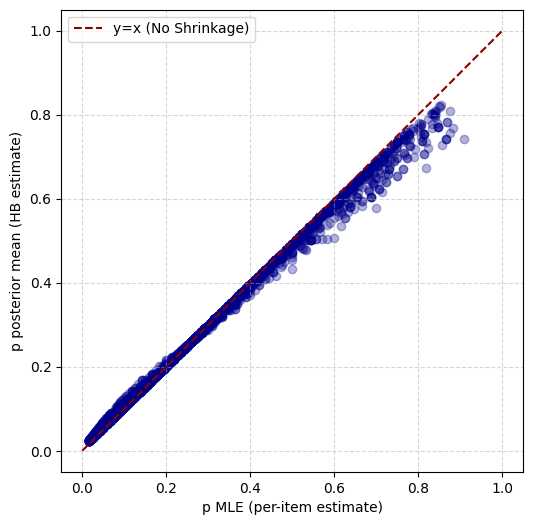

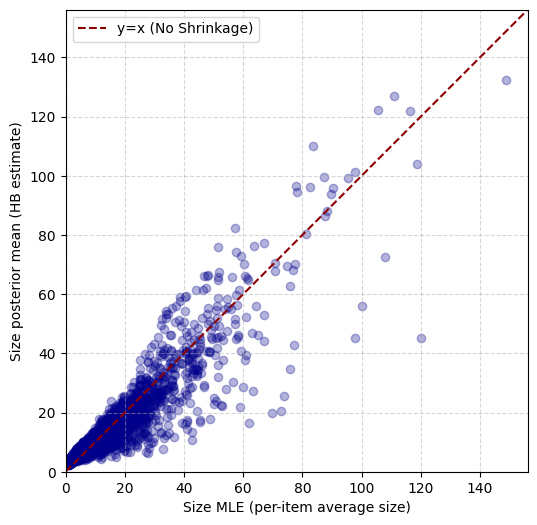

In [ ]:
# --- 2. Plotting section (MODIFIED WITH NEW COLOR SCHEME) ---
# Plot 1: Shrinkage on p
fig, ax = plt.subplots(figsize=(7, 6))
# CHANGED: Points are now dark blue, dashed line is dark red
ax.scatter(plot_df['p_mle'], plot_df['p_posterior'], color='darkblue', alpha=0.3)
ax.plot([0, 1], [0, 1], '--', color='darkred', label='y=x (No Shrinkage)')
ax.set_xlabel('p MLE (per-item estimate)')
ax.set_ylabel('p posterior mean (HB estimate)')
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_aspect('equal', adjustable='box')
ax.legend()
plt.show()

# Plot 2: Shrinkage on Size
lim_max = max(plot_df['size_mle'].max(), plot_df['size_posterior'].max()) * 1.05
lim_min = 0
fig, ax = plt.subplots(figsize=(7, 6))
# CHANGED: Points are now dark blue, dashed line is dark red
ax.scatter(plot_df['size_mle'], plot_df['size_posterior'], color='darkblue', alpha=0.3)
ax.plot([lim_min, lim_max], [lim_min, lim_max], '--', color='darkred', label='y=x (No Shrinkage)')
ax.set_xlabel('Size MLE (per-item average size)')
ax.set_ylabel('Size posterior mean (HB estimate)')
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_xlim(lim_min, lim_max)
ax.set_ylim(lim_min, lim_max)
ax.set_aspect('equal', adjustable='box')
ax.legend()
plt.show()

#Performance Segmentation Analysis

In [ ]:
# ==============================================================================
# 實驗一：性能細分分析 (Performance Segmentation Analysis)
# ==============================================================================
# 假設前一個程式碼區塊中的以下變數已經存在且可被存取：
# - init_set, eval_set_merged (資料)
# - n, s (用於計算 ADI)
# - my_me, my_mae, my_rmse (指標函數)
# - rmsse_denominators (RMSSE 計算所需的分母)
# ==============================================================================

print("\nRunning Experiment 1: Performance Segmentation Analysis...")

# --- Step 1: Calculate ADI and CV² for each series from the initial set ---
print("Step 1/4: Calculating ADI and CV² for each series...")

# For CV², we only consider periods with actual demand
demand_events = init_set[init_set['y'] > 0]
series_stats = demand_events.groupby('unique_id')['y'].agg(['mean', 'std']).reset_index()
series_stats['cv_sq'] = (series_stats['std'] / series_stats['mean']) ** 2
series_stats['cv_sq'].fillna(0, inplace=True) # If std is NaN (e.g., only one sale), CV² is 0

# For ADI, we use the counts 's' (demand occurrences) and 'n' (total period length)
# from the previous section. This is the most accurate way.
adi_df = pd.DataFrame({
    'n': n,
    's': s
}).reset_index()

# Avoid division by zero for series that might have had no sales in the init set
adi_df['adi'] = np.where(adi_df['s'] > 0, adi_df['n'] / adi_df['s'], adi_df['n'])

# Combine into a single characteristics dataframe
series_characteristics = pd.merge(series_stats[['unique_id', 'cv_sq']], adi_df[['unique_id', 'adi']], on='unique_id')

# --- Step 2: Classify series into four categories ---
print("Step 2/4: Classifying series into categories...")

def classify_series(row):
    adi_threshold = 1.32
    cv2_threshold = 0.49
    if row['adi'] <= adi_threshold and row['cv_sq'] <= cv2_threshold:
        return 'Smooth'
    elif row['adi'] > adi_threshold and row['cv_sq'] <= cv2_threshold:
        return 'Intermittent'
    elif row['adi'] <= adi_threshold and row['cv_sq'] > cv2_threshold:
        return 'Erratic'
    else: # adi > adi_threshold and cv_sq > cv2_threshold
        return 'Lumpy'

series_characteristics['category'] = series_characteristics.apply(classify_series, axis=1)
category_counts = series_characteristics['category'].value_counts()
print("\nSeries counts per category:")
print(category_counts)

# --- Step 3: Merge categories into the main evaluation results ---
print("\nStep 3/4: Merging categories with evaluation results...")

eval_with_cats = pd.merge(eval_set_merged, series_characteristics[['unique_id', 'category']], on='unique_id', how='left')

# --- Step 4: Calculate metrics for each segment and display results ---
print("Step 4/4: Calculating and displaying segmented metrics...")

segmented_results = []
models_to_eval = [col for col in eval_with_cats.columns if col not in ['unique_id', 'ds', 'y', 'category']]
categories = sorted([cat for cat in eval_with_cats['category'].unique() if pd.notna(cat)])

for category in categories:
    subset_df = eval_with_cats[eval_with_cats['category'] == category]

    for model in models_to_eval:
        # Create a temporary df for this specific model and category
        temp_df = subset_df[['unique_id', 'y', model]].copy()
        temp_df.rename(columns={model: 'y_pred'}, inplace=True)
        temp_df.dropna(subset=['y_pred'], inplace=True)

        # --- Calculate ME, MAE, RMSE (Global for the category) ---
        y_true_cat = temp_df['y'].values
        y_pred_cat = temp_df['y_pred'].values

        me_val = my_me(y_true_cat, y_pred_cat)
        mae_val = my_mae(y_true_cat, y_pred_cat)
        rmse_val = my_rmse(y_true_cat, y_pred_cat)

        # --- Calculate RMSSE (Per-series within the category) ---
        temp_df = temp_df.merge(rmsse_denominators.rename('rmsse_denom'), on='unique_id', how='left')
        temp_df['model_sq_err'] = (temp_df['y'] - temp_df['y_pred'])**2
        mse_per_series_cat = temp_df.groupby('unique_id')['model_sq_err'].mean()
        denom_per_series_cat = temp_df.groupby('unique_id')['rmsse_denom'].first()
        scaled_error_sq_cat = mse_per_series_cat / denom_per_series_cat
        rmsse_val = np.sqrt(np.nanmean(scaled_error_sq_cat))

        segmented_results.append({
            'category': category,
            'model': model,
            'ME': me_val,
            'MAE': mae_val,
            'RMSE': rmse_val,
            'RMSSE': rmsse_val
        })

segmented_results_df = pd.DataFrame(segmented_results)

# --- Display Results in Pivoted Tables for Easy Comparison ---
print("\n\n" + "="*55)
print("      PERFORMANCE SEGMENTATION RESULTS (FULL METRICS)")
print("="*55)

# Order categories for logical presentation
category_order = ['Smooth', 'Erratic', 'Intermittent', 'Lumpy']
category_order_present = [c for c in category_order if c in segmented_results_df['category'].unique()]

# ME Results
me_pivot = segmented_results_df.pivot(index='model', columns='category', values='ME')[category_order_present]
print("\n--- ME (Mean Error) by Demand Category ---")
print(me_pivot.round(4))

# MAE Results
mae_pivot = segmented_results_df.pivot(index='model', columns='category', values='MAE')[category_order_present]
print("\n--- MAE (Mean Absolute Error) by Demand Category ---")
print(mae_pivot.round(4))

# RMSE Results
rmse_pivot = segmented_results_df.pivot(index='model', columns='category', values='RMSE')[category_order_present]
print("\n--- RMSE (Root Mean Squared Error) by Demand Category ---")
print(rmse_pivot.round(4))

# RMSSE Results
rmsse_pivot = segmented_results_df.pivot(index='model', columns='category', values='RMSSE')[category_order_present]
print("\n--- RMSSE (Root Mean Squared Scaled Error) by Demand Category ---")
print(rmsse_pivot.round(4))
print("\n" + "="*55)


Running Experiment 1: Performance Segmentation Analysis...
Step 1/4: Calculating ADI and CV² for each series...
Step 2/4: Classifying series into categories...

Series counts per category:
category
Lumpy           2524
Intermittent    1041
Erratic           75
Smooth             9
Name: count, dtype: int64

Step 3/4: Merging categories with evaluation results...
Step 4/4: Calculating and displaying segmented metrics...


/tmp/ipython-input-1917520714.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  series_stats['cv_sq'].fillna(0, inplace=True) # If std is NaN (e.g., only one sale), CV² is 0




      PERFORMANCE SEGMENTATION RESULTS (FULL METRICS)

--- ME (Mean Error) by Demand Category ---
category           Smooth  Erratic  Intermittent     Lumpy
model                                                     
ADIDA              1.2140  -3.4233       -0.5477   -0.7922
AutoARIMA        -13.9045  -3.0178       -0.5364   -1.0883
AutoTheta         -6.7035 -14.7454       -0.8064   -1.9404
CrostonClassic     4.6784  -1.2778        0.7624    0.0318
CrostonSBA         3.5826  -2.9120        0.6695   -0.2458
IMAPA              1.2140  -3.4233       -0.5547   -0.7893
TSB                3.4240  -4.6869       -0.5759   -1.8663
TSB-HB-LogNormal   6.6647   2.6143       -0.1514   -1.0729
index             11.0209  40.4057      100.9274  108.4294

--- MAE (Mean Absolute Error) by Demand Category ---
category           Smooth  Erratic  Intermittent     Lumpy
model                                                     
ADIDA             15.4399  30.3260        1.3098    6.7629
AutoARIMA         28

#Ablation Study

In [ ]:
# ==============================================================================
# 實驗二：模型消融研究 (Ablation Study)
# ==============================================================================
# 假設前一個程式碼區塊中的以下變數已經存在且可被存取：
# - init_set, eval_set_merged (資料)
# - g_init, s, n, p_post_mean (HB 模型相關統計量)
# - my_me, my_mae, my_rmse (指標函數)
# - rmsse_denominators (RMSSE 計算所需的分母)
# ==============================================================================

print("\nRunning Experiment 2: Ablation Study...")

# --- Ablation Model A: TSB-MLE-LogNormal (保持不變) ---
p_mle = s / n

item_stats_for_mle = init_set.groupby('unique_id')['log_size'].agg(
    mean_log='mean', var_log='var'
).fillna(0)

item_stats_for_mle['size_mle_lognormal'] = np.exp(
    item_stats_for_mle['mean_log'] + (item_stats_for_mle['var_log'] / 2)
)

forecast_mle = (p_mle * item_stats_for_mle['size_mle_lognormal']).fillna(0)
print("  - TSB-MLE-LogNormal forecast created.")


# --- Ablation Model B: TSB-HB-Gamma (修正版) ---
print("Building TSB-HB-Gamma (corrected)...")

# B1. 計算每個 item 的 MLE
# λᵢ_MLE = (總需求量) / (需求發生次數)
item_stats_gamma = g_init.agg({
    'size': 'sum',   # 總需求量
    'occ': 'sum'     # 需求發生次數
})

# 計算 λ_MLE (只對有需求的 item)
lambda_mle = item_stats_gamma['size'] / item_stats_gamma['occ']
lambda_mle = lambda_mle.replace([np.inf, -np.inf], np.nan)

# B2. 估計 Gamma 超參數 (從 λ_MLE 的分佈)
def estimate_gamma_hyperparams(lambda_hats: pd.Series):
    lam = lambda_hats.dropna()
    lam = lam[lam > 0]
    if lam.empty or len(lam) < 2:
        return 1.0, 1.0

    m = lam.mean()
    v = lam.var()
    v = max(v, 1e-6)

    # Gamma: E[λ] = a/b, Var[λ] = a/b²
    # => a = m²/v, b = m/v
    a = m * m / v
    b = m / v

    return float(max(a, 1e-3)), float(max(b, 1e-6))

a_hat, b_hat = estimate_gamma_hyperparams(lambda_mle)
print(f"  - Gamma Hyperpriors: a={a_hat:.4f}, b={b_hat:.4f}")

# B3. 計算每個 item 的後驗預測均值
# 後驗: Gamma(a + Σyᵢⱼ, b + nᵢ)
# E[size] = (a + Σyᵢⱼ) / (b + nᵢ)
alpha_post = a_hat + item_stats_gamma['size']
beta_post = b_hat + item_stats_gamma['occ']

size_posterior_gamma = alpha_post / beta_post
size_posterior_gamma = size_posterior_gamma.replace([np.inf, -np.inf], 0).fillna(0)

# B4. 組合預測
forecast_gamma = (p_post_mean * size_posterior_gamma).fillna(0)
print("  - TSB-HB-Gamma forecast created.")

# 繼續後續評估...


# --- Step 2: Merge Ablated Forecasts into the Evaluation Set ---
print("Step 2/3: Merging ablated forecasts for evaluation...")

# Start with the evaluation dataframe we already have
ablation_eval_df = eval_set_merged.copy()

# Add the two new models' forecasts
ablation_eval_df = ablation_eval_df.merge(
    forecast_mle.rename('TSB-MLE-LogNormal'), on='unique_id', how='left'
)
ablation_eval_df['TSB-MLE-LogNormal'] = ablation_eval_df['TSB-MLE-LogNormal'].fillna(0)

ablation_eval_df = ablation_eval_df.merge(
    forecast_gamma.rename('TSB-HB-Gamma'), on='unique_id', how='left'
)
ablation_eval_df['TSB-HB-Gamma'] = ablation_eval_df['TSB-HB-Gamma'].fillna(0)


# --- Step 3: Calculate Metrics and Display Full Results Table ---
print("Step 3/3: Calculating and displaying ablation study results...")

ablation_results = []
models_for_ablation = [col for col in ablation_eval_df.columns if col not in ['unique_id', 'ds', 'y']]

for model in models_for_ablation:
    # Create a temporary df for this model's evaluation
    temp_df = ablation_eval_df[['unique_id', 'y', model]].copy()
    temp_df.rename(columns={model: 'y_pred'}, inplace=True)
    temp_df.dropna(subset=['y_pred'], inplace=True)

    # --- Global metrics (ME, MAE, RMSE) ---
    y_true_all = temp_df['y'].values
    y_pred_all = temp_df['y_pred'].values

    me_val = my_me(y_true_all, y_pred_all)
    mae_val = my_mae(y_true_all, y_pred_all)
    rmse_val = my_rmse(y_true_all, y_pred_all)

    # --- RMSSE Calculation (per series) ---
    temp_df = temp_df.merge(rmsse_denominators.rename('rmsse_denom'), on='unique_id', how='left')
    temp_df['model_sq_err'] = (temp_df['y'] - temp_df['y_pred'])**2
    mse_per_series = temp_df.groupby('unique_id')['model_sq_err'].mean()
    scaled_error_sq = mse_per_series / temp_df.groupby('unique_id')['rmsse_denom'].first()
    rmsse_val = np.sqrt(np.nanmean(scaled_error_sq))

    ablation_results.append({
        "model": model,
        "ME": me_val,
        "MAE": mae_val,
        "RMSE": rmse_val,
        "RMSSE": rmsse_val
    })

ablation_results_df = pd.DataFrame(ablation_results)

# Sort by RMSSE to easily see the hierarchy of performance
ablation_results_df = ablation_results_df.sort_values("RMSSE").set_index('model')

print("\n\n" + "="*60)
print("                 ABLATION STUDY RESULTS (FULL METRICS)")
print("="*60)
print(ablation_results_df.round(4))
print("\n" + "="*60)


Running Experiment 2: Ablation Study...
  - TSB-MLE-LogNormal forecast created.
Building TSB-HB-Gamma (corrected)...
  - Gamma Hyperpriors: a=0.6728, b=0.0572
  - TSB-HB-Gamma forecast created.
Step 2/3: Merging ablated forecasts for evaluation...
Step 3/3: Calculating and displaying ablation study results...


                 ABLATION STUDY RESULTS (FULL METRICS)
                         ME       MAE      RMSE     RMSSE
model                                                    
TSB-HB-Gamma        -0.6749    5.7380   17.7035    4.7881
TSB-HB-LogNormal    -0.7972    5.6575   17.7773    4.7887
ARIMA               -0.6244    5.7515   17.7078    4.7910
TSB-MLE-LogNormal   -0.1145    5.9931   17.7577    4.7912
ADIDA               -0.7603    5.6860   17.9617    4.7967
IMAPA               -0.7599    5.7000   17.9963    4.7970
TSB                 -1.6255    5.5783   18.8125    4.8041
Theta               -1.5152    7.1675   20.0804    4.8404
CrostonSBA          -0.0468    6.1953   18.1633    

#TSB Grid search

In [ ]:
# ==============================================================================
# 實驗五：基線模型參數敏感度分析 (Hyperparameter Sensitivity Analysis)
# ==============================================================================

print("\nRunning Experiment 5: Hyperparameter Sensitivity Analysis for TSB Baseline...")

# --- Step 1: Define the Hyperparameter Grid ---
# Using a grid similar to the one in the reference paper
alphas = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
betas = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
param_grid = [(a, b) for a in alphas for b in betas]

# --- Step 2: Get the performance of your TSB-HB-LogNormal model ---
# We run this once as its performance is independent of these parameters.
# We can retrieve this from the previous ablation study results.
your_model_results = ablation_results_df.loc['TSB-HB-LogNormal']
print(f"Performance of your TSB-HB-LogNormal model (for comparison):")
print(your_model_results)


# --- Step 3: Loop through the grid, run TSB, and evaluate ---
tuning_results = []
total_combinations = len(param_grid)

for i, (alpha, beta) in enumerate(param_grid):
    print(f"\n[{i+1}/{total_combinations}] Testing TSB with alpha={alpha}, beta={beta}...")

    # 1. Instantiate StatsForecast with the specific TSB parameters
    sf_tsb = StatsForecast(
        models=[TSB(alpha_d=alpha, alpha_p=beta)],
        freq='D',
        n_jobs=-1
    )

    # 2. Fit and Predict (using the same fixed-origin loop)
    tsb_forecasts = []
    for uid in valid_ids:
        h = eval_set_lengths.get(uid, 0)
        if h > 0:
            uid_init_df = init_set[init_set['unique_id'] == uid][['unique_id', 'ds', 'y']]
            if not uid_init_df.empty:
                sf_tsb.fit(df=uid_init_df)
                forecast = sf_tsb.predict(h=h)
                tsb_forecasts.append(forecast)

    tsb_fcst_df = pd.concat(tsb_forecasts).reset_index()

    # 3. Merge and Evaluate
    eval_temp_df = eval_set[['unique_id', 'ds', 'y']].copy()
    eval_temp_df = eval_temp_df.merge(tsb_fcst_df, on=['unique_id', 'ds'], how='left')

    y_true = eval_temp_df['y'].values
    y_pred = eval_temp_df['TSB'].values
    valid_indices = ~np.isnan(y_pred)

    # Calculate metrics for this TSB configuration
    me = -np.nanmean(y_true[valid_indices] - y_pred[valid_indices]) # ME = mean(actual - forecast), so we negate our mean(forecast - actual)
    mae = my_mae(y_true[valid_indices], y_pred[valid_indices])
    rmse = my_rmse(y_true[valid_indices], y_pred[valid_indices])

    # Calculate RMSSE for this configuration
    # Get in-sample errors for scaling factor
    in_sample_naive_errors_sq = init_set.groupby('unique_id')['y'].diff().pow(2)
    scaling_factor = in_sample_naive_errors_sq.groupby(init_set['unique_id']).mean()

    # Calculate out-of-sample errors
    out_of_sample_errors_sq = (eval_temp_df['y'] - eval_temp_df['TSB']).pow(2)
    mse_per_series = out_of_sample_errors_sq.groupby(eval_temp_df['unique_id']).mean()

    # Calculate RMSSE
    msse_per_series = mse_per_series / scaling_factor
    rmsse = np.sqrt(msse_per_series.mean())

    # 4. Store results
    tuning_results.append({
        'model': 'TSB',
        'alpha': alpha,
        'beta': beta,
        'ME': me,
        'MAE': mae,
        'RMSE': rmse,
        'RMSSE': rmsse,
        'HB_MAE': your_model_results['MAE'], # Add your model's result for easy comparison
        'HB_RMSE': your_model_results['RMSE']
    })

# --- Step 4: Convert to DataFrame and Save to CSV ---
tuning_results_df = pd.DataFrame(tuning_results)

print("\n\n" + "="*60)
print("      HYPERPARAMETER TUNING RESULTS FOR TSB BASELINE")
print("="*60)
# Display sorted by the most important metric, MAE
print(tuning_results_df.sort_values("MAE").round(4))
print("\n" + "="*60)


# Save the detailed results to a CSV file
output_filename = 'hyperparameter_tuning_results.csv'
tuning_results_df.to_csv(output_filename, index=False)
print(f"\nFull results have been saved to '{output_filename}'")


Running Experiment 5: Hyperparameter Sensitivity Analysis for TSB Baseline...
Performance of your TSB-HB-LogNormal model (for comparison):
ME       -1.099343
MAE       5.518985
RMSE     17.805409
RMSSE     4.789259
Name: TSB-HB-LogNormal, dtype: float64

[1/36] Testing TSB with alpha=0.05, beta=0.05...

[2/36] Testing TSB with alpha=0.05, beta=0.1...

[3/36] Testing TSB with alpha=0.05, beta=0.15...

[4/36] Testing TSB with alpha=0.05, beta=0.2...

[5/36] Testing TSB with alpha=0.05, beta=0.25...

[6/36] Testing TSB with alpha=0.05, beta=0.3...

[7/36] Testing TSB with alpha=0.1, beta=0.05...

[8/36] Testing TSB with alpha=0.1, beta=0.1...

[9/36] Testing TSB with alpha=0.1, beta=0.15...


#probability forecast

In [ ]:
# ====================================================================================
# CELL 1: PROBABILISTIC FORECASTING EXPERIMENT (TSB-HB vs. AutoARIMA vs. AutoTheta)
# ====================================================================================

# --- 0) Setup and Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.optimize as opt
from scipy.stats import norm
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoTheta # Added AutoTheta
import random
import os
from tqdm.auto import tqdm # For progress bars

# --- A) Set Random Seed for Reproducibility ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
print(f"Random seed set to {SEED} for reproducibility.\n")


# --- 1) Load + Preprocess (Identical to previous script) ---
print("--- Step 1: Loading and Preprocessing Data ---")
try:
    FILE = "/content/drive/MyDrive/AISTATS2026/Online_Retail.csv"
    df_raw = pd.read_csv(FILE, encoding="latin1")
except FileNotFoundError:
    print("ERROR: 'Online_Retail.csv' not found. Please upload the file or mount your Drive.")
    pd.DataFrame({
        'InvoiceDate': pd.to_datetime(['2011-12-01']), 'StockCode': ['A'],
        'Quantity': [1], 'UnitPrice': [1]
    }).to_csv(FILE, index=False)
    df_raw = pd.read_csv(FILE, encoding="latin1")

df = df_raw[["InvoiceDate", "StockCode", "Quantity", "UnitPrice"]].copy()
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)].copy()
q_cap = df['Quantity'].quantile(0.995)
df['Quantity'] = df['Quantity'].clip(upper=q_cap)
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["ds"] = df["InvoiceDate"].dt.date
df = df.groupby(["StockCode", "ds"], as_index=False)["Quantity"].sum()
df = df.rename(columns={"StockCode":"unique_id", "Quantity":"y"})
df["ds"] = pd.to_datetime(df["ds"])
df = df.set_index('ds').groupby('unique_id')['y'].apply(
    lambda x: x.asfreq('D', fill_value=0)
).reset_index()
df = df.sort_values(["unique_id", "ds"])
print("Data preprocessing complete.\n")


# --- 2) Train/Test split (Identical to previous script) ---
print("--- Step 2: Splitting Data ---")
INIT_RATIO = 1/3
MIN_LEN = 30
df['t'] = df.groupby('unique_id').cumcount()
df['L'] = df.groupby('unique_id')['t'].transform('max') + 1
df = df[df['L'] >= MIN_LEN].copy()
init_set = df[df['t'] < np.floor(df['L'] * INIT_RATIO)].copy()
eval_set = df[df['t'] >= np.floor(df['L'] * INIT_RATIO)].copy()
valid_ids = df['unique_id'].unique()
print(f"Data split into {len(valid_ids)} series for training and evaluation.\n")


# --- 3) Fit TSB-HB and gather parameters (Adapted from previous script) ---
print("--- Step 3: Fitting TSB-HB Model ---")
init_set["occ"] = (init_set["y"] > 0).astype(int)
init_set["size"] = np.where(init_set["occ"]==1, init_set["y"].astype(float), np.nan)
init_set["log_size"] = np.log(init_set["size"])
g_init = init_set.groupby("unique_id")
s = g_init["occ"].sum()
n = g_init["ds"].nunique()

def beta_binom_log_marginal(s:int, n:int, alpha:float, beta:float)->float:
    if alpha <= 0 or beta <= 0 or s < 0 or n < s: return -np.inf
    return (
        math.lgamma(n + 1) - math.lgamma(s + 1) - math.lgamma(n - s + 1) +
        math.lgamma(s + alpha) + math.lgamma(n - s + beta) - math.lgamma(n + alpha + beta) -
        (math.lgamma(alpha) + math.lgamma(beta) - math.lgamma(alpha + beta))
    )

def estimate_beta_hyperparams(counts: pd.DataFrame):
    s_arr, n_arr = counts["s"].astype(int).values, counts["n"].astype(int).values
    valid_indices = (n_arr > 0) & (s_arr <= n_arr)
    s_arr, n_arr = s_arr[valid_indices], n_arr[valid_indices]
    def objective_fn(params):
        alpha, beta = params
        if alpha <= 0 or beta <= 0: return np.inf
        log_likelihoods = [beta_binom_log_marginal(si, ni, alpha, beta) for si, ni in zip(s_arr, n_arr)]
        return -sum(log_likelihoods)
    result = opt.minimize(fun=objective_fn, x0=[1.0, 10.0], method='L-BFGS-B', bounds=[(1e-6, None), (1e-6, None)])
    return float(result.x[0]), float(result.x[1])

alpha_hat, beta_hat = estimate_beta_hyperparams(pd.DataFrame({"s": s, "n": n}))
p_post_mean = (alpha_hat + s) / (alpha_hat + beta_hat + n)

item_stats = init_set.groupby('unique_id')['log_size'].agg(n_pos='count', mean_log='mean', var_log='var').reset_index()
item_stats_filtered = item_stats[item_stats['n_pos'] > 1].copy().fillna({'var_log': 0})
numerator = np.sum((item_stats_filtered['n_pos'] - 1) * item_stats_filtered['var_log'])
denominator = np.sum(item_stats_filtered['n_pos'] - 1)
sigma_sq = numerator / denominator if denominator > 0 else 1e-6

y_i = item_stats_filtered['mean_log'].values
n_i = item_stats_filtered['n_pos'].values
def reml_neg_log_likelihood(tau_sq):
    if tau_sq <= 0: return np.inf
    V_i = tau_sq + sigma_sq / n_i
    weights = 1 / V_i
    mu_hat = np.sum(weights * y_i) / np.sum(weights)
    return np.sum(np.log(V_i)) + np.sum((y_i - mu_hat)**2 / V_i) + np.log(np.sum(weights))
observed_var = np.var(y_i, ddof=1) if len(y_i) > 1 else 0
avg_sampling_var = np.mean(sigma_sq / n_i) if len(n_i) > 0 else 0
tau_sq_mom = max(observed_var - avg_sampling_var, 1e-6)
reml_result = opt.minimize(reml_neg_log_likelihood, x0=[tau_sq_mom], method='L-BFGS-B', bounds=[(1e-9, None)])
tau_sq_reml = max(reml_result.x[0], 1e-6) if reml_result.success else tau_sq_mom

V_i_final = tau_sq_reml + sigma_sq / n_i
weights_final = 1 / V_i_final
global_mean = np.sum(weights_final * y_i) / np.sum(weights_final) if np.sum(weights_final) > 0 else 0

item_stats = item_stats.merge(
    pd.DataFrame({'unique_id': item_stats_filtered['unique_id'], 'credibility': n_i / (n_i + sigma_sq / tau_sq_reml)}),
    on='unique_id', how='left'
).fillna({'credibility': 0})

item_stats['shrunk_mean_log'] = (
    item_stats['credibility'] * item_stats['mean_log'].fillna(global_mean) +
    (1 - item_stats['credibility']) * global_mean
)
item_stats['posterior_var_mu'] = (sigma_sq * tau_sq_reml) / (item_stats['n_pos'] * tau_sq_reml + sigma_sq)
item_stats.loc[item_stats['n_pos'] == 0, 'posterior_var_mu'] = tau_sq_reml
tsb_hb_params = item_stats.set_index('unique_id')
tsb_hb_params['p_posterior'] = p_post_mean
tsb_hb_params['sigma_sq_process'] = sigma_sq
print("TSB-HB parameters estimated successfully.\n")


# --- 4) Generate Probabilistic Forecasts ---
print("--- Step 4: Generating Probabilistic Forecasts ---")
N_SAMPLES = 2000
QUANTILES = [0.10, 0.25, 0.50, 0.75, 0.90]

# --- 4.1) TSB-HB Probabilistic Forecasts ---
def generate_tsb_hb_samples(uid, n_samples, params_df):
    params = params_df.loc[uid]
    p = params['p_posterior']
    demand_occurs = np.random.binomial(1, p, n_samples)
    pred_mean = params['shrunk_mean_log']
    pred_var = params['sigma_sq_process'] + params['posterior_var_mu']
    pred_std = np.sqrt(pred_var)
    log_samples = norm.rvs(loc=pred_mean, scale=pred_std, size=n_samples)
    size_samples = np.exp(log_samples)
    final_samples = size_samples * demand_occurs
    return final_samples

print("Generating TSB-HB forecast samples (this may take a moment)...")
tsb_hb_samples = {}
for uid in tqdm(valid_ids):
    tsb_hb_samples[uid] = generate_tsb_hb_samples(uid, N_SAMPLES, tsb_hb_params)

tsb_hb_q_forecasts = []
for uid, samples in tsb_hb_samples.items():
    h = len(eval_set[eval_set['unique_id'] == uid])
    if h > 0:
        q_preds = {f'q_{q}': np.quantile(samples, q) for q in QUANTILES}
        df_q = pd.DataFrame(q_preds, index=pd.RangeIndex(h))
        df_q['unique_id'] = uid
        df_q['ds'] = eval_set[eval_set['unique_id'] == uid]['ds'].values
        tsb_hb_q_forecasts.append(df_q)
tsb_hb_q_fcst_df = pd.concat(tsb_hb_q_forecasts)
print("TSB-HB quantile forecasts created.")

# --- 4.2) AutoARIMA and AutoTheta Probabilistic Forecasts ---
levels = [80, 50]
# ADDED AutoTheta to the list of models
sf = StatsForecast(models=[AutoARIMA(season_length=7), AutoTheta(season_length=7)], freq='D', n_jobs=-1)

print("Generating AutoARIMA and AutoTheta quantile forecasts (this will be slow)...")
all_statsforecast_fcsts = []
eval_set_lengths = eval_set['unique_id'].value_counts()

for uid in tqdm(valid_ids):
    h = eval_set_lengths.get(uid, 0)
    if h > 0:
        uid_init_df = init_set[init_set['unique_id'] == uid][['unique_id', 'ds', 'y']]
        if not uid_init_df.empty:
            sf.fit(df=uid_init_df)
            forecast = sf.forecast(df=uid_init_df, h=h, level=levels)
            all_statsforecast_fcsts.append(forecast)

statsforecast_q_fcst_df = pd.concat(all_statsforecast_fcsts)

# Prepare separate dataframes for each model for evaluation
arima_q_fcst_df = statsforecast_q_fcst_df[['AutoARIMA', 'AutoARIMA-lo-80', 'AutoARIMA-hi-80', 'AutoARIMA-lo-50', 'AutoARIMA-hi-50']].copy()
theta_q_fcst_df = statsforecast_q_fcst_df[['AutoTheta', 'AutoTheta-lo-80', 'AutoTheta-hi-80', 'AutoTheta-lo-50', 'AutoTheta-hi-50']].copy()

# Rename columns for consistency
arima_q_fcst_df.rename(columns={
    'AutoARIMA': 'q_0.5', 'AutoARIMA-lo-80': 'q_0.1', 'AutoARIMA-hi-80': 'q_0.9',
    'AutoARIMA-lo-50': 'q_0.25', 'AutoARIMA-hi-50': 'q_0.75'
}, inplace=True)

theta_q_fcst_df.rename(columns={
    'AutoTheta': 'q_0.5', 'AutoTheta-lo-80': 'q_0.1', 'AutoTheta-hi-80': 'q_0.9',
    'AutoTheta-lo-50': 'q_0.25', 'AutoTheta-hi-50': 'q_0.75'
}, inplace=True)
print("AutoARIMA and AutoTheta quantile forecasts created.\n")


# --- 5) Evaluate Probabilistic Forecasts using Pinball Loss ---
print("--- Step 5: Evaluating Forecasts with Pinball Loss ---")
def pinball_loss(y_true, y_pred, q):
    error = y_true - y_pred
    return np.maximum(q * error, (q - 1) * error)

eval_merged = eval_set[['unique_id', 'ds', 'y']].copy()
tsb_hb_eval = eval_merged.merge(tsb_hb_q_fcst_df, on=['unique_id', 'ds'])
arima_eval = eval_merged.merge(arima_q_fcst_df.reset_index(), on=['unique_id', 'ds'])
theta_eval = eval_merged.merge(theta_q_fcst_df.reset_index(), on=['unique_id', 'ds'])

results = []
# ADDED AutoTheta to the evaluation loop
for model_name, df_eval in [('TSB-HB', tsb_hb_eval), ('AutoARIMA', arima_eval), ('AutoTheta', theta_eval)]:
    model_results = {'model': model_name}
    for q in QUANTILES:
        # Important: drop NA values for each model's predictions before calculating loss
        df_eval_clean = df_eval.dropna(subset=['y', f'q_{q}'])
        loss = pinball_loss(df_eval_clean['y'], df_eval_clean[f'q_{q}'], q).mean()
        model_results[f'Pinball Loss (q={q})'] = loss
    results.append(model_results)

results_df = pd.DataFrame(results)
results_df['Mean Pinball Loss'] = results_df[[f'Pinball Loss (q={q})' for q in QUANTILES]].mean(axis=1)

print("\n=== Probabilistic Forecasting Results (Pinball Loss) ===")
print("Lower is better.")
print(results_df.round(4))

Random seed set to 42 for reproducibility.

--- Step 1: Loading and Preprocessing Data ---
Data preprocessing complete.

--- Step 2: Splitting Data ---
Data split into 3649 series for training and evaluation.

--- Step 3: Fitting TSB-HB Model ---
TSB-HB parameters estimated successfully.

--- Step 4: Generating Probabilistic Forecasts ---
Generating TSB-HB forecast samples (this may take a moment)...


  0%|          | 0/3649 [00:00<?, ?it/s]

TSB-HB quantile forecasts created.
Generating AutoARIMA and AutoTheta quantile forecasts (this will be slow)...


  0%|          | 0/3649 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/statsforecast/arima.py:1867: UserWarning: Stepwise search was stopped early due to reaching the model number limit: nmodels=94
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsforecast/arima.py:1867: UserWarning: Stepwise search was stopped early due to reaching the model number limit: nmodels=94
  warnings.warn(


AutoARIMA and AutoTheta quantile forecasts created.

--- Step 5: Evaluating Forecasts with Pinball Loss ---


KeyError: 'unique_id'

In [ ]:
# ====================================================================================
# CELL 2: FIX AND COMPLETE THE EVALUATION (RUN THIS AFTER THE ERROR)
# ====================================================================================

print("--- Salvaging results from the previous run ---")

# --- Step 1: Reconstruct the StatsForecast DataFrame with 'unique_id' ---
# The list 'all_statsforecast_fcsts' is still in memory. We will iterate through it
# and add back the 'unique_id' that was lost during the original concatenation.
print("Step 1/3: Reconstructing the forecast DataFrame...")

reconstructed_fcsts = []
# We assume the order of forecasts in 'all_statsforecast_fcsts' matches 'valid_ids'
# which is correct based on the loop structure.
# We also need to get the correct 'ds' for each forecast.
current_pos = 0
for uid in tqdm(valid_ids):
    h = eval_set_lengths.get(uid, 0)
    if h > 0:
        uid_init_df_len = len(init_set[init_set['unique_id'] == uid])
        if uid_init_df_len > 0:
            # Find the corresponding forecast chunk in the concatenated dataframe
            forecast_chunk = statsforecast_q_fcst_df.iloc[current_pos : current_pos + h].copy()
            forecast_chunk['unique_id'] = uid
            forecast_chunk['ds'] = eval_set[eval_set['unique_id'] == uid]['ds'].values
            reconstructed_fcsts.append(forecast_chunk)
            current_pos += h

statsforecast_q_fcst_df_fixed = pd.concat(reconstructed_fcsts)


# --- Step 2: Re-create the model-specific forecast DataFrames ---
print("Step 2/3: Re-creating model-specific DataFrames...")

# Prepare separate dataframes for each model for evaluation
arima_q_fcst_df_fixed = statsforecast_q_fcst_df_fixed[['unique_id', 'ds', 'AutoARIMA', 'AutoARIMA-lo-80', 'AutoARIMA-hi-80', 'AutoARIMA-lo-50', 'AutoARIMA-hi-50']].copy()
theta_q_fcst_df_fixed = statsforecast_q_fcst_df_fixed[['unique_id', 'ds', 'AutoTheta', 'AutoTheta-lo-80', 'AutoTheta-hi-80', 'AutoTheta-lo-50', 'AutoTheta-hi-50']].copy()

# Rename columns for consistency
arima_q_fcst_df_fixed.rename(columns={
    'AutoARIMA': 'q_0.5', 'AutoARIMA-lo-80': 'q_0.1', 'AutoARIMA-hi-80': 'q_0.9',
    'AutoARIMA-lo-50': 'q_0.25', 'AutoARIMA-hi-50': 'q_0.75'
}, inplace=True)

theta_q_fcst_df_fixed.rename(columns={
    'AutoTheta': 'q_0.5', 'AutoTheta-lo-80': 'q_0.1', 'AutoTheta-hi-80': 'q_0.9',
    'AutoTheta-lo-50': 'q_0.25', 'AutoTheta-hi-50': 'q_0.75'
}, inplace=True)


# --- Step 3: Evaluate Probabilistic Forecasts using Pinball Loss (Corrected) ---
print("Step 3/3: Evaluating Forecasts with Pinball Loss...")

eval_merged = eval_set[['unique_id', 'ds', 'y']].copy()

# This merge should now work correctly
tsb_hb_eval = eval_merged.merge(tsb_hb_q_fcst_df, on=['unique_id', 'ds'])
arima_eval = eval_merged.merge(arima_q_fcst_df_fixed, on=['unique_id', 'ds'])
theta_eval = eval_merged.merge(theta_q_fcst_df_fixed, on=['unique_id', 'ds'])

results = []
QUANTILES = [0.10, 0.25, 0.50, 0.75, 0.90] # Make sure QUANTILES is defined

for model_name, df_eval in [('TSB-HB', tsb_hb_eval), ('AutoARIMA', arima_eval), ('AutoTheta', theta_eval)]:
    model_results = {'model': model_name}
    total_loss_per_q = []
    for q in QUANTILES:
        # Important: drop NA values for each model's predictions before calculating loss
        df_eval_clean = df_eval.dropna(subset=['y', f'q_{q}'])
        loss = pinball_loss(df_eval_clean['y'], df_eval_clean[f'q_{q}'], q).mean()
        model_results[f'Pinball Loss (q={q})'] = loss
        total_loss_per_q.append(loss)

    model_results['Mean Pinball Loss'] = np.mean(total_loss_per_q)
    results.append(model_results)

results_df = pd.DataFrame(results)

print("\n\n" + "="*60)
print("      PROBABILISTIC FORECASTING RESULTS (Pinball Loss)")
print("="*60)
print("Lower is better.")
# Sort by the main summary metric
print(results_df.sort_values('Mean Pinball Loss').round(4))
print("\n" + "="*60)

# Save the final results to a CSV
output_filename_prob = 'probabilistic_forecast_pinball_results.csv'
results_df.to_csv(output_filename_prob, index=False)
print(f"\nFinal probabilistic results have been saved to '{output_filename_prob}'")

--- Salvaging results from the previous run ---
Step 1/3: Reconstructing the forecast DataFrame...


  0%|          | 0/3649 [00:00<?, ?it/s]

Step 2/3: Re-creating model-specific DataFrames...
Step 3/3: Evaluating Forecasts with Pinball Loss...


      PROBABILISTIC FORECASTING RESULTS (Pinball Loss)
Lower is better.
       model  Pinball Loss (q=0.1)  ...  Pinball Loss (q=0.9)  Mean Pinball Loss
0     TSB-HB                0.4755  ...                2.6704             1.9202
1  AutoARIMA                1.7090  ...                2.9148             2.8576
2  AutoTheta                2.3564  ...                3.0963             3.4822

[3 rows x 7 columns]


Final probabilistic results have been saved to 'probabilistic_forecast_pinball_results.csv'


##Cocerage&PIT



      COVERAGE AND INTERVAL WIDTH RESULTS
       model  Coverage@80  AIW@80
0     TSB-HB        0.900  10.184
1  AutoARIMA        0.905  28.400
2  AutoTheta        0.940  42.088


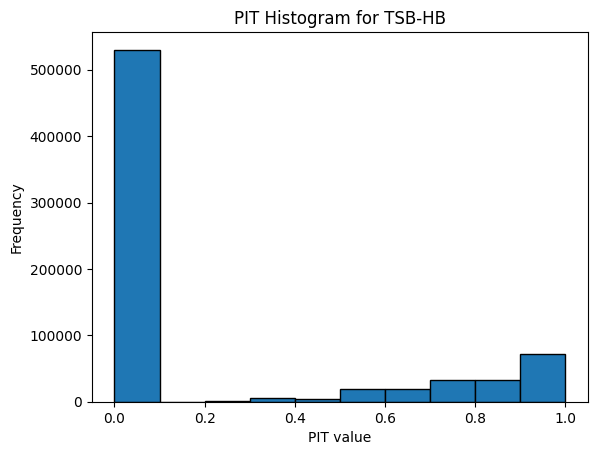

In [ ]:
# ====================================================================================
# NEW CELL: COVERAGE + PIT ANALYSIS
# ====================================================================================

import matplotlib.pyplot as plt

def coverage_rate(df, lower_q, upper_q, alpha):
    """計算區間覆蓋率與平均區間寬度 (AIW)"""
    cover = ((df['y'] >= df[f'q_{lower_q}']) & (df['y'] <= df[f'q_{upper_q}'])).mean()
    width = (df[f'q_{upper_q}'] - df[f'q_{lower_q}']).mean()
    return {f'Coverage@{int(alpha*100)}': cover, f'AIW@{int(alpha*100)}': width}

coverage_results = []

for model_name, df_eval in [('TSB-HB', tsb_hb_eval),
                            ('AutoARIMA', arima_eval),
                            ('AutoTheta', theta_eval)]:
    model_cov = {'model': model_name}
    # 80% interval = q0.1–q0.9
    model_cov.update(coverage_rate(df_eval, 0.1, 0.9, 0.8))
    # 如果有 q0.025 / q0.975，就可以做 95% (這裡先檢查有沒有欄位)
    if 'q_0.025' in df_eval and 'q_0.975' in df_eval:
        model_cov.update(coverage_rate(df_eval, 0.025, 0.975, 0.95))
    coverage_results.append(model_cov)

coverage_df = pd.DataFrame(coverage_results)
print("\n\n" + "="*60)
print("      COVERAGE AND INTERVAL WIDTH RESULTS")
print("="*60)
print(coverage_df.round(3))
print("="*60)

# -------------------------
# PIT (Probability Integral Transform)
# -------------------------
# 以中位數 q0.5 或更細分位數集合構造 CDF
# 簡化版：用分位集合近似 inverse CDF

def compute_pit(df, quantiles=[0.1,0.25,0.5,0.75,0.9]):
    pit_values = []
    for _, row in df.iterrows():
        y = row['y']
        qs = [row[f'q_{q}'] for q in quantiles]
        # 找到 y 落在哪兩個分位之間
        if y <= qs[0]:
            pit = 0.0
        elif y >= qs[-1]:
            pit = 1.0
        else:
            for i in range(len(quantiles)-1):
                if qs[i] <= y <= qs[i+1]:
                    # 線性內插
                    q_low, q_high = quantiles[i], quantiles[i+1]
                    pit = q_low + (q_high - q_low) * (y - qs[i])/(qs[i+1]-qs[i])
                    break
        pit_values.append(pit)
    return np.array(pit_values)

# 畫一張 PIT 直方圖 (只畫 TSB-HB 以展示校準)
pit_vals = compute_pit(tsb_hb_eval)
plt.hist(pit_vals, bins=10, range=(0,1), edgecolor='black')
plt.title("PIT Histogram for TSB-HB")
plt.xlabel("PIT value")
plt.ylabel("Frequency")
plt.show()


#M5

In [ ]:
# Step 1: 在您的環境中，請先安裝必要的函式庫
# !pip install statsforecast statsmodels

import pandas as pd
import numpy as np
import math
import scipy.optimize as opt
from statsforecast import StatsForecast
from statsforecast.models import CrostonClassic, CrostonSBA, TSB, ADIDA, IMAPA
import random
import os

# ==============================================================================
# 0. SETUP AND CONFIGURATION
# ==============================================================================
print("--- 0. Setup and Configuration ---")
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# 設定抽樣 5000 條序列
N_SERIES_SAMPLE = 5000
INIT_RATIO = 2/3

# ==============================================================================
# 1. DATA LOADING AND PREPROCESSING
# ==============================================================================
print("\n--- 1. Data Loading and Preprocessing ---")

try:
    # 請確認這些路徑在您的環境中是正確的
    sales_df = pd.read_csv('/content/drive/MyDrive/AISTATS2026/m5_evaluation_long.csv')
    calendar_df = pd.read_csv('/content/drive/MyDrive/AISTATS2026/calendar.csv')
    print("M5 data files loaded successfully.")
except FileNotFoundError as e:
    print(f"ERROR: {e}")
    print("找不到檔案，請檢查您的檔案路徑是否正確。")
    sales_df = pd.DataFrame()

if not sales_df.empty:
    # --- 為長格式資料調整腳本 ---
    print("Adjusting script for long-format data...")
    if 'series_id' in sales_df.columns:
        sales_df.rename(columns={'series_id': 'id', 'sales': 'y'}, inplace=True)

    # --- 抽樣 ---
    if N_SERIES_SAMPLE is not None and 'id' in sales_df.columns:
        print(f"Sampling {N_SERIES_SAMPLE} series from the dataset...")
        unique_ids = sales_df['id'].unique()
        if len(unique_ids) < N_SERIES_SAMPLE:
            N_SERIES_SAMPLE = len(unique_ids)
        sampled_ids = random.sample(list(unique_ids), N_SERIES_SAMPLE)
        sales_df = sales_df[sales_df['id'].isin(sampled_ids)].copy()

    # --- 與日曆合併 ---
    sales_long_df = sales_df
    calendar_df = calendar_df[['d', 'date']]
    calendar_df['date'] = pd.to_datetime(calendar_df['date'])
    df = pd.merge(sales_long_df, calendar_df, on='d', how='left')

    # --- 最終前處理 ---
    df.rename(columns={"id": "unique_id", "date": "ds"}, inplace=True)
    df.dropna(subset=['ds'], inplace=True)
    df = df[['unique_id', 'ds', 'y']].sort_values(['unique_id', 'ds']).reset_index(drop=True)
    print(f"Preprocessing complete. Total rows: {len(df)}, Unique series: {df['unique_id'].nunique()}")

    # ==============================================================================
    # 2. TRAIN/TEST SPLIT (FIXED ORIGIN)
    # ==============================================================================
    print("\n--- 2. Train/Test Split ---")
    df['t'] = df.groupby('unique_id').cumcount()
    df['L'] = df.groupby('unique_id')['t'].transform('max') + 1
    init_set = df[df['t'] < np.floor(df['L'] * INIT_RATIO)].copy()
    eval_set = df[df['t'] >= np.floor(df['L'] * INIT_RATIO)].copy()
    valid_ids = df['unique_id'].unique()
    print(f"Initial Set Shape: {init_set.shape}")
    print(f"Evaluation Set Shape: {eval_set.shape}")

    # ==============================================================================
    # 3. TSB-HB MODEL IMPLEMENTATION AND TRAINING
    # ==============================================================================
    print("\n--- 3. TSB-HB Model Training ---")
    init_set["occ"] = (init_set["y"] > 0).astype(int)
    init_set["size"] = np.where(init_set["occ"]==1, init_set["y"].astype(float), np.nan)
    init_set["log_size"] = np.log(init_set["size"])
    g_init = init_set.groupby("unique_id")
    s = g_init["occ"].sum()
    n = g_init["ds"].nunique()

    def beta_binom_log_marginal(s:int, n:int, alpha:float, beta:float)->float:
        if alpha <= 0 or beta <= 0 or s < 0 or n < s: return -np.inf
        return (
            math.lgamma(n + 1) - math.lgamma(s + 1) - math.lgamma(n - s + 1) +
            math.lgamma(s + alpha) + math.lgamma(n - s + beta) - math.lgamma(n + alpha + beta) -
            (math.lgamma(alpha) + math.lgamma(beta) - math.lgamma(alpha + beta))
        )

    def estimate_beta_hyperparams(counts: pd.DataFrame):
        s_arr, n_arr = counts["s"].astype(int).values, counts["n"].astype(int).values
        def objective_fn(params):
            alpha, beta = params
            if alpha <= 0 or beta <= 0: return np.inf
            log_likelihoods = [beta_binom_log_marginal(si, ni, alpha, beta) for si, ni in zip(s_arr, n_arr)]
            return -sum(log_likelihoods)
        result = opt.minimize(fun=objective_fn, x0=[1.0, 10.0], method='L-BFGS-B', bounds=[(1e-6, None), (1e-6, None)])
        if result.success:
            alpha, beta = result.x
            print(f"Beta-Binomial fit successful: alpha={alpha:.4f}, beta={beta:.4f}")
            return float(alpha), float(beta)
        print("Beta-Binomial fit failed. Using defaults.")
        return 1.0, 1.0

    def estimate_log_normal_posterior_mean_REML(df_init):
        item_stats = df_init.groupby('unique_id')['log_size'].agg(
            n_pos='count', mean_log='mean', var_log='var'
        ).reset_index().fillna({'var_log': 0})
        item_stats = item_stats[item_stats['n_pos'] > 1].copy()
        if item_stats.empty: return pd.Series(dtype=float)
        numerator = np.sum((item_stats['n_pos'] - 1) * item_stats['var_log'])
        denominator = np.sum(item_stats['n_pos'] - 1)
        sigma_sq = numerator / denominator if denominator > 0 else 1e-6
        y_i, n_i = item_stats['mean_log'].values, item_stats['n_pos'].values
        observed_var = np.var(y_i, ddof=1) if len(y_i) > 1 else 0
        avg_sampling_var = np.mean(sigma_sq / n_i) if len(n_i) > 0 else 0
        tau_sq_mom = max(observed_var - avg_sampling_var, 1e-6)
        def reml_neg_log_likelihood(tau_sq):
            if tau_sq <= 0: return np.inf
            V_i = tau_sq + sigma_sq / n_i
            w = 1 / V_i
            mu_hat = np.sum(w * y_i) / np.sum(w)
            return np.sum(np.log(V_i)) + np.sum((y_i - mu_hat)**2 / V_i) + np.log(np.sum(w))
        res = opt.minimize(reml_neg_log_likelihood, x0=[tau_sq_mom], method='L-BFGS-B', bounds=[(1e-9, None)])
        tau_sq_reml = max(res.x[0], 1e-6) if res.success else tau_sq_mom
        print(f"Log-Normal REML fit: sigma_sq={sigma_sq:.4f}, tau_sq={tau_sq_reml:.4f}")
        k_reml = sigma_sq / tau_sq_reml if tau_sq_reml > 1e-9 else float('inf')
        V_i = tau_sq_reml + sigma_sq / n_i
        weights = 1 / V_i
        global_mean = np.sum(weights * y_i) / np.sum(weights) if np.sum(weights) > 0 else np.mean(y_i)
        item_stats['credibility'] = item_stats['n_pos'] / (item_stats['n_pos'] + k_reml)
        item_stats['shrunk_mean_log'] = (item_stats['credibility'] * item_stats['mean_log'] + (1 - item_stats['credibility']) * global_mean)
        item_stats['pred_size'] = np.exp(item_stats['shrunk_mean_log'] + (sigma_sq / 2))
        return item_stats.set_index('unique_id')['pred_size']

    alpha_hat, beta_hat = estimate_beta_hyperparams(pd.DataFrame({"s": s, "n": n}))
    p_post_mean = (alpha_hat + s) / (alpha_hat + beta_hat + n)
    size_pred_mean = estimate_log_normal_posterior_mean_REML(init_set)
    mean_pred_hb = (p_post_mean * size_pred_mean).fillna(0)
    print("TSB-HB training complete.")

    # ==============================================================================
    # 4. BASELINE MODELS TRAINING AND FORECASTING (高效能版本)
    # ==============================================================================
    print("\n--- 4. Baseline Models Training and Forecasting ---")
    sf = StatsForecast(
        models=[CrostonClassic(), CrostonSBA(), TSB(alpha_d=0.5, alpha_p=0.45), ADIDA(), IMAPA()],
        freq='D',
        n_jobs=-1
    )

    print("Fitting all series at once (this will be much faster)...")
    sf.fit(init_set)

    print("Predicting all series...")
    h_values = eval_set.groupby('unique_id').size().max()
    fcst_df = sf.predict(h=int(h_values))

    eval_horizon = eval_set[['unique_id', 'ds']]
    fcst_df = fcst_df.merge(eval_horizon, on=['unique_id', 'ds'], how='inner').reset_index(drop=True)
    print("Baseline forecasting complete.")

    # ==============================================================================
    # 5. POINT FORECAST EVALUATION
    # ==============================================================================
    print("\n--- 5. Evaluating Point Forecasts ---")

    def my_me(y, yhat): return float(np.nanmean(yhat - y))
    def my_mae(y, yhat): return float(np.nanmean(np.abs(yhat - y)))
    def my_rmse(y, yhat): return float(np.sqrt(np.nanmean((yhat - y)**2)))

    # --- Step 5.1: 計算 RMSSE 的分母 ---
    print("Calculating naive error for RMSSE denominator...")
    init_set_sorted = init_set.sort_values(['unique_id', 'ds'])
    init_set_sorted['y_lag1'] = init_set_sorted.groupby('unique_id')['y'].shift(1)
    init_set_sorted['naive_sq_err'] = (init_set_sorted['y'] - init_set_sorted['y_lag1'])**2
    epsilon = 1e-9
    rmsse_denominators = init_set_sorted.groupby('unique_id')['naive_sq_err'].mean()
    rmsse_denominators = rmsse_denominators.where(rmsse_denominators > 0, epsilon)
    print(f"Calculated RMSSE denominators for {len(rmsse_denominators)} series.")

    # --- Step 5.2: 合併所有預測與真實值 ---
    eval_set_merged = eval_set[['unique_id', 'ds', 'y']].copy()
    eval_set_merged = eval_set_merged.merge(fcst_df, on=['unique_id', 'ds'], how='left')
    eval_set_merged = eval_set_merged.merge(
        mean_pred_hb.rename('TSB-HB'), on='unique_id', how='left'
    )
    eval_set_merged['TSB-HB'].fillna(0, inplace=True)

    # --- Step 5.3: 為每個模型計算指標 ---
    results = []
    models_to_eval = [col for col in eval_set_merged.columns if col not in ['unique_id', 'ds', 'y']]

    for model in models_to_eval:
        print(f"Evaluating model: {model}...")
        temp_df = eval_set_merged[['unique_id', 'y', model]].copy()
        temp_df.rename(columns={model: 'y_pred'}, inplace=True)
        temp_df.dropna(subset=['y_pred'], inplace=True)

        y_true_all = temp_df['y'].values
        y_pred_all = temp_df['y_pred'].values

        # --- 全局指標 (ME, MAE, RMSE) ---
        me_val = my_me(y_true_all, y_pred_all)
        mae_val = my_mae(y_true_all, y_pred_all)
        rmse_val = my_rmse(y_true_all, y_pred_all)

        # --- RMSSE 計算 (分序列計算誤差，再平均) ---
        temp_df = temp_df.merge(rmsse_denominators.rename('rmsse_denom'), on='unique_id', how='left')
        temp_df['model_sq_err'] = (temp_df['y'] - temp_df['y_pred'])**2
        mse_per_series = temp_df.groupby('unique_id')['model_sq_err'].mean()

        series_eval = pd.concat([mse_per_series.rename('model_mse'),
                                 temp_df.groupby('unique_id')['rmsse_denom'].first()], axis=1)

        series_eval['scaled_err_sq'] = series_eval['model_mse'] / series_eval['rmsse_denom']
        rmsse_val = np.sqrt(np.nanmean(series_eval['scaled_err_sq']))

        results.append({
            "model": model, "ME": me_val, "MAE": mae_val, "RMSE": rmse_val, "RMSSE": rmsse_val
        })

    results_df = pd.DataFrame(results)

    # --- 最終結果呈現 ---
    print("\n" + "="*55)
    print("           POINT FORECAST EVALUATION RESULTS")
    print("="*55)
    print(results_df.sort_values("RMSSE").round(4))
    print("\n" + "="*55)

else:
    print("\nExecution halted because data file could not be loaded.")